In [1]:
import numpy
import mitsuba as mi 
mi.set_variant("cuda_ad_rgb")
import matplotlib.patches as patches
from matplotlib import colors
import drjit as dr
import numpy as np
import matplotlib.pyplot as plt
from PDE2D.Coefficient import *
from PDE2D.utils import *
from PDE2D.Sampling import *
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
from matplotlib.widgets import Slider
from mitsuba import Point2f, Float, PCG32, UInt64, Texture2f
from PDE2D import DIM

In [2]:
num_points = 2 ** 12
sampler = PCG32()
sampler.seed(initstate = dr.arange(UInt64, num_points), initseq = dr.arange(UInt64, num_points))

In [3]:
def get_mean_free_image(R_scale = [0, 1], sigma_scale = [0.01, 10000], spp = 2**8, resolution = [256, 256]):
    image = np.zeros(resolution)
    image = dr.cuda.ad.TensorXf(image)
    R = R_scale[0] + (R_scale[1] - R_scale[0]) * dr.arange(Float, resolution[0]) / (resolution[0] - 1) 
    σ = sigma_scale[0] * 2 ** (dr.arange(Float, resolution[1]) / (resolution[1] - 1) * dr.log2(sigma_scale[1] / sigma_scale[0]))
    RR, σσ = dr.meshgrid(R, σ, indexing = 'ij')
    RR = dr.repeat(RR, spp)
    σσ = dr.repeat(σσ, spp)
    sample = dr.arange(Float, spp) / spp + 1/(2 * spp)
    sample = dr.tile(sample, (resolution[0]) * resolution[1]) 
    green = GreensFunctionAnalytic(dim = DIM.Two, newton_steps = 5)
    r, Gnorm = green.sample(sample, RR, σσ)
    prob_boundary = 1 - σσ * Gnorm
    z = Float(RR * dr.sqrt(σσ))
    result = r * (1-prob_boundary) + RR * prob_boundary
    result = dr.select(RR == 0, 0, result)
    result = TensorXf(dr.block_sum(result, spp) / spp)
    result = dr.reshape(TensorXf, result, shape = [resolution[0], resolution[1], 1])
    result_tex = Texture2f(result)
    return result, result_tex

In [4]:
R_scale = [0, 1]
sigma_scale = [0.01, 10000]
resolution = [256, 256]
result_image, tex= get_mean_free_image(R_scale = R_scale, sigma_scale=sigma_scale, resolution = resolution)

Text(0.5, 0, 'majorant')

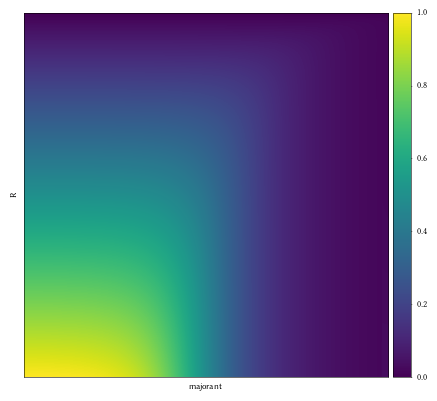

In [5]:
fig, ax = plt.subplots(1,1, figsize = [5,5])
plot_image(result_image, ax, input_range = [0,1])
ax.set_ylabel("R")
ax.set_xlabel("majorant")

In [9]:
def get_mean_free_path(R, σ, Rscale, σscale):
    resolution = result_image.shape
    Rgrid = 1 / resolution[0]
    σgrid = 1 / resolution[1]
    ind_R =  Rgrid / 2 + (R - Rscale[0]) / (Rscale[1] - Rscale[0]) * (1.0-Rgrid) 
    ind_σ = σgrid/2 + dr.log2(σ / σscale[0]) / dr.log2(σscale[1] / σscale[0]) * (1.0 - σgrid)
    return tex.eval(Point2f(ind_σ, ind_R))[0]

In [10]:
R = R_scale[0] + (R_scale[1] - R_scale[0]) * dr.arange(Float, resolution[0]) / (resolution[0] - 1) 
σ = sigma_scale[0] * 2 ** (dr.arange(Float, resolution[1]) / (resolution[1] - 1) * dr.log2(sigma_scale[1] / sigma_scale[0]))
RR, σσ = dr.meshgrid(R, σ, indexing = 'ij')
vals = get_mean_free_path(RR, σσ, R_scale, sigma_scale)
vals = TensorXf(vals)
vals = dr.reshape(TensorXf, vals, [resolution[0], resolution[1], 1])

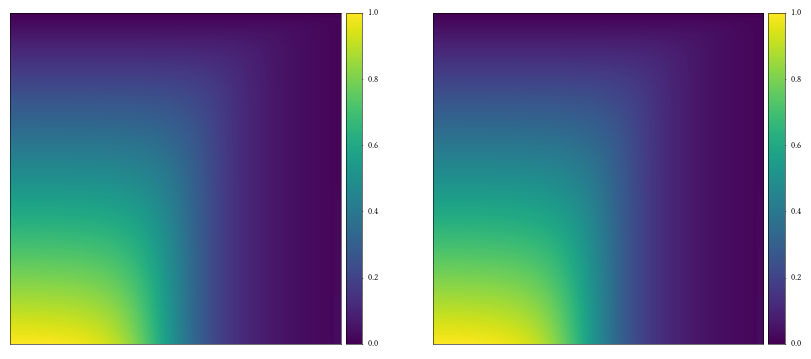

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [10,5])
plot_image(vals, ax1, input_range = [0,1])
plot_image(result_image, ax2, input_range = [0,1])

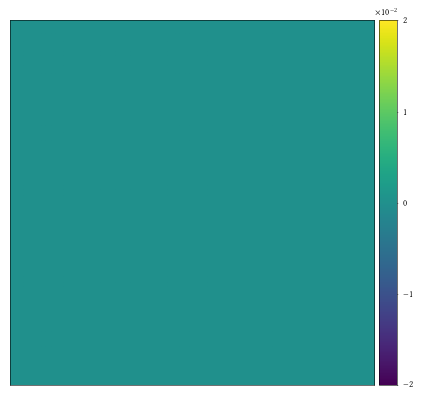

In [12]:
fig, (ax) = plt.subplots(1,1, figsize = [5,5])
plot_image(result_image- vals, ax, input_range = [-0.02,0.02])